### Задание

Обучить модель векторизации на задаче мультиклассовой классификации текстов.

1. Выбрать датасет для задачи классификации текстов (https://huggingface.co/datasets)
2. Выбрать модель векторизации (https://huggingface.co/models)
3. Обучить классификатор с mean_pooling.
4. Посчитать метрики: F1-Score, Precision, Recall. (https://lightning.ai/docs/torchmetrics/stable/)
5. Обучить классификатор с cls_pooling.
6. Посчитать метрики: F1-Score, Precision, Recall.
7. Сравнить метрики полученные при использовании разных стратегий пулинга.

In [1]:
import torch
import pandas as pd
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import datasets
from collections import Counter

### Data preprocessing

In [2]:
ds = datasets.load_dataset("rootacess/math-qa-classification")

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['Problem', 'category'],
        num_rows: 29837
    })
    validation: Dataset({
        features: ['Problem', 'category'],
        num_rows: 4475
    })
    test: Dataset({
        features: ['Problem', 'category'],
        num_rows: 2985
    })
})

In [4]:
Counter(ds['train']['category'])

Counter({0: 13273, 1: 7063, 2: 5120, 3: 2117, 5: 1814, 4: 450})

In [5]:
label2id = {
    "general": 0,
    "physics": 1,
    "gain": 2,
    "geometry": 3,
    "probability": 4,
    "other": 5
}
label2id

{'general': 0,
 'physics': 1,
 'gain': 2,
 'geometry': 3,
 'probability': 4,
 'other': 5}

In [6]:
id2label = {v:k for k,v in label2id.items()}
id2label

{0: 'general',
 1: 'physics',
 2: 'gain',
 3: 'geometry',
 4: 'probability',
 5: 'other'}

In [7]:
text_legnths = [len(t) for t in ds['train']['Problem']]

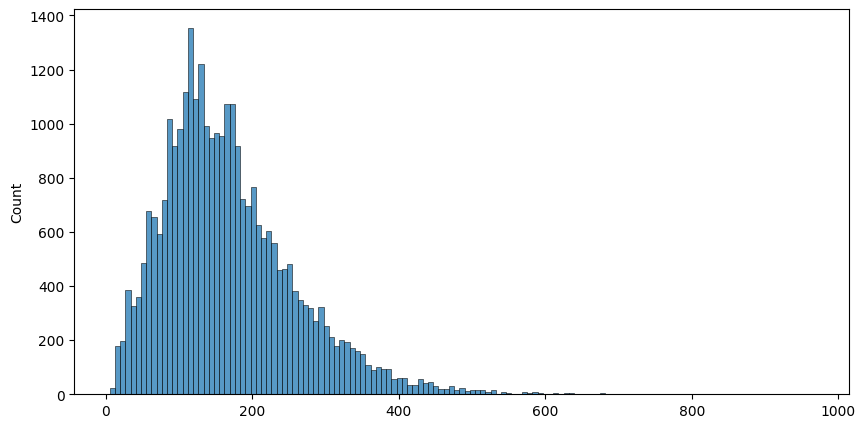

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(data=text_legnths)
plt.show()

In [9]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.DataFrame.from_dict(ds['train'][:20])

,Problem,category
0,the banker ' s gain of a certain sum due 3 years hence at 10 % per annum is rs . 36 . what is the present worth ?,2
1,average age of students of an adult school is 40 years . 120 new students whose average age is 32 years joined the school . as a result the average age is decreased by 4 years . find the number of students of the school after joining of the new students .,0
2,sophia finished 2 / 3 of a book . she calculated that she finished 90 more pages than she has yet to read . how long is her book ?,0
3,120 is what percent of 50 ?,2
4,there are 10 girls and 20 boys in a classroom . what is the ratio of girls to boys ?,5
5,"an empty fuel tank with a capacity of 218 gallons was filled partially with fuel a and then to capacity with fuel b . fuel a contains 12 % ethanol by volume and fuel b contains 16 % ethanol by volume . if the full fuel tank contains 30 gallons of ethanol , how many gallons of fuel a were added ?",2
6,"an article is bought for rs . 823 and sold for rs . 1000 , find the gain percent ?",2
7,6 workers should finish a job in 8 days . after 3 days came 4 workers join them . how many days m do they need to finish the same job ?,1
8,j is 25 % less than p and 20 % less than t . t is q % less than p . what is the value of q ?,2
9,"a student was asked to find 4 / 5 of a number . but the student divided the number by 4 / 5 , thus the student got 36 more than the correct answer . find the number .",0


### Tokenization

In [ ]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('ibm-granite/granite-embedding-30m-english')

def tokenize_data(data, max_length=512):
    texts = data['Problem']
    texts = list(texts)
    tokens = tokenizer.batch_encode_plus(
        texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return tokens


train_tokens = tokenize_data(ds['train'])
val_tokens = tokenize_data(ds['validation'])
test_tokens = tokenize_data(ds['test'])

In [11]:
print(train_tokens.input_ids.shape)

torch.Size([29837, 512])


In [12]:
train_dataset = TensorDataset(
    train_tokens['input_ids'],
    train_tokens['attention_mask'],
    torch.tensor(ds['train']['category'], dtype=torch.long),
)

val_dataset = TensorDataset(
    val_tokens['input_ids'],
    val_tokens['attention_mask'],
    torch.tensor(ds['validation']['category'], dtype=torch.long),
)

test_dataset = TensorDataset(
    test_tokens['input_ids'],
    test_tokens['attention_mask'],
    torch.tensor(ds['test']['category'], dtype=torch.long),
)

In [13]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Loading Pretrained

In [14]:
device = 'mps' if torch.backends.mps.is_built() else 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


### Fine-Tuning with Mean Pooling

In [15]:
import torch.nn.functional as F


def avg_train_and_val(
        model,
        loader: DataLoader,
        epoch,
        num_epochs,
        optimizer,
        mode,
):
    total_loss = 0

    for input_ids, attention_mask, labels in tqdm(loader, desc=f'{mode} epoch {epoch}/{num_epochs}...'):
        if mode == 'Training':
            optimizer.zero_grad()

        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        outputs_loss = F.cross_entropy(logits, labels)

        total_loss += outputs_loss.item()

        if mode == 'Training':
            outputs_loss.backward()
            optimizer.step()

    loss = total_loss / len(loader)
    print(f'{mode} epoch {epoch + 1}/{num_epochs}: {mode} Loss: {loss:.4f}')

In [16]:
def avg_train(
        model,
        train_loader,
        val_loader,
        optimizer,
        num_epochs=3,
):
    for epoch in range(num_epochs):
        model.train()

        avg_train_and_val(model, train_loader, epoch, num_epochs, optimizer, mode='Training')

        model.eval()

        with torch.no_grad():
            avg_train_and_val(model, val_loader, epoch, num_epochs, optimizer, mode='Validating')

In [17]:
class Classifier(torch.nn.Module):
    def __init__(self, pretrained, pooling_type):
        super(Classifier, self).__init__()
        self.pooling_type = pooling_type
        self.pretrained = pretrained
        self.classifier = torch.nn.Linear(384, 6)

    def mean_pooling(
        self,
        token_embeddings: torch.Tensor,
        attention_mask: torch.Tensor
    ):
        input_mask_expanded = (
            attention_mask.unsqueeze(-1).expand(token_embeddings.shape).float()
        )
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
            input_mask_expanded.sum(1), min=1e-9
        )

    def cls_pooling(
        self,
        token_embeddings: torch.Tensor,
        attention_mask: torch.Tensor
    ):
      return token_embeddings[:,0]

    def forward(self, input_ids, attention_mask):
        outputs = self.pretrained(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        if self.pooling_type == 'mean':
          embeddings = self.mean_pooling(outputs.last_hidden_state, attention_mask)
        elif self.pooling_type == 'cls':
          embeddings = self.cls_pooling(outputs.last_hidden_state, attention_mask)
        logits = self.classifier(embeddings)

        return logits


In [ ]:
pretrained = AutoModel.from_pretrained(
    'ibm-granite/granite-embedding-30m-english',
    output_hidden_states=True,
)

classifier = Classifier(pretrained, 'mean')
classifier = classifier.to(device)

optimizer = torch.optim.AdamW(classifier.parameters(), lr=5e-5)

In [ ]:
avg_train(classifier, train_loader, val_loader, optimizer)

In [20]:
def eval_model(model, loader):
    preds = []
    labels = []
    model.eval()
    with torch.no_grad():
        for input_ids, attention_mask, label in tqdm(loader):
            logits = model(
                input_ids=input_ids.to(device),
                attention_mask=attention_mask.to(device),
            )

            sentiment = torch.argmax(logits, dim=1).tolist()
            for i in range(len(label)):
                preds.append(sentiment[i])
                labels.append(label[i].item())

    return preds, labels

In [21]:
loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [22]:
preds_mean, labels_mean = eval_model(classifier, loader)

100%|██████████| 187/187 [00:13<00:00, 13.40it/s]


In [23]:
pretrained = AutoModel.from_pretrained(
    'ibm-granite/granite-embedding-30m-english',
    output_hidden_states=True,
)

classifier = Classifier(pretrained, 'cls')
classifier = classifier.to(device)

optimizer = torch.optim.AdamW(classifier.parameters(), lr=5e-5)

In [24]:
avg_train(classifier, train_loader, val_loader, optimizer)

Training epoch 0/3...: 100%|██████████| 933/933 [08:05<00:00,  1.92it/s]


Training epoch 1/3: Training Loss: 0.2989


Validating epoch 0/3...: 100%|██████████| 140/140 [00:20<00:00,  6.88it/s]


Validating epoch 1/3: Validating Loss: 0.1199


Training epoch 1/3...: 100%|██████████| 933/933 [08:05<00:00,  1.92it/s]


Training epoch 2/3: Training Loss: 0.0831


Validating epoch 1/3...: 100%|██████████| 140/140 [00:20<00:00,  6.87it/s]


Validating epoch 2/3: Validating Loss: 0.0572


Training epoch 2/3...: 100%|██████████| 933/933 [08:05<00:00,  1.92it/s]


Training epoch 3/3: Training Loss: 0.0414


Validating epoch 2/3...: 100%|██████████| 140/140 [00:20<00:00,  6.87it/s]

Validating epoch 3/3: Validating Loss: 0.0588


In [25]:
preds_cls, labels_cls = eval_model(classifier, loader)

100%|██████████| 187/187 [00:13<00:00, 13.53it/s]


In [26]:
class_labels = [i[1] for i in sorted(id2label.items())]

## Compare labels and preds here

In [27]:
from sklearn.metrics import classification_report
print(classification_report(labels_mean, preds_mean,target_names=class_labels))

              precision    recall  f1-score   support

     general       0.98      0.99      0.99      1301
     physics       0.99      0.99      0.99       702
        gain       0.98      0.99      0.98       558
    geometry       0.98      0.97      0.98       200
 probability       1.00      0.98      0.99        52
       other       0.99      0.98      0.99       172

    accuracy                           0.99      2985
   macro avg       0.99      0.98      0.99      2985
weighted avg       0.99      0.99      0.99      2985



In [28]:
print(classification_report(labels_cls, preds_cls,target_names=class_labels))

              precision    recall  f1-score   support

     general       0.99      0.98      0.98      1301
     physics       0.97      0.99      0.98       702
        gain       0.97      0.99      0.98       558
    geometry       0.98      0.98      0.98       200
 probability       0.98      0.90      0.94        52
       other       0.96      0.93      0.94       172

    accuracy                           0.98      2985
   macro avg       0.98      0.96      0.97      2985
weighted avg       0.98      0.98      0.98      2985

